## 1. Import libraries.

Install libraries.

In [1]:
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes 
!conda install -c conda-forge wordcloud==1.4.1 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    libc

Import libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from wordcloud import WordCloud, STOPWORDS

## 1. Download and Explore Dataset

Download json file and load the data.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Take *features* from the dataset.

In [5]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## 2. Transform the data into a *pandas* dataframe.

Create an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Loop through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = data['properties']['borough']
    neighborhood_name = data['properties']['name']        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Print the numbers of boroughs and neighborhoods.

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


## 3. Plot the geographical location of each neighborhood on the map.

Get the geographical location of the New York City.

In [9]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
staten_island_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)

In [11]:
map_new_york = folium.Map(location=[latitude, longitude], zoom_start=11)

Define a function to add markers on the map.

In [12]:
def add_marker(m_latitude, m_longitude, m_neighborhood, m_color, m_fill_color, m_map):
    for lat, lng, label in zip(m_latitude, m_longitude, m_neighborhood):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=4,
            popup=label,
            color=m_color,
            fill=True,
            fill_color=m_fill_color,
            fill_opacity=0.7,
            parse_html=False).add_to(m_map)

Add markers to the New York City map.

In [13]:
# add manhattan markers to map
add_marker(manhattan_data['Latitude'],
           manhattan_data['Longitude'],
           manhattan_data['Neighborhood'],
           'blue',
           '#3186cc',
           map_new_york)

In [14]:
# add brooklyn markers to map
add_marker(brooklyn_data['Latitude'],
           brooklyn_data['Longitude'],
           brooklyn_data['Neighborhood'],
           'red',
           '#cc3150',
           map_new_york)

In [15]:
# add queens markers to map
add_marker(queens_data['Latitude'],
           queens_data['Longitude'],
           queens_data['Neighborhood'],
           'green',
           '#31cc4b',
           map_new_york)

In [16]:
# add bronx markers to map
add_marker(bronx_data['Latitude'],
           bronx_data['Longitude'],
           bronx_data['Neighborhood'],
           'yellow',
           '#ccc431',
           map_new_york)

In [17]:
# add staten island markers to map
add_marker(staten_island_data['Latitude'],
           staten_island_data['Longitude'],
           staten_island_data['Neighborhood'],
           'purple',
           '#8431cc',
           map_new_york)

Show the neighborhood map.

In [18]:
map_new_york

## 4. Request venue data from Foursquare.

Define Foursquare Credentials and Version.

In [19]:
secrets = json.load(open('credential.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = '20200101'

Limit of number of venues returned by Foursquare API

In [20]:
LIMIT = 100 

Define function to extract the category of the venue.

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a function to get the nearby venues of each neighborhood that are within 500 meter radius.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe called *manhattan_venues*, *brooklyn_venues*, *queens_venues*, *bronx_venues*, and *staten_island_venues*.

In [23]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

In [24]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

In [25]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

In [26]:
bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )

In [27]:
staten_island_venues = getNearbyVenues(names=staten_island_data['Neighborhood'],
                                   latitudes=staten_island_data['Latitude'],
                                   longitudes=staten_island_data['Longitude']
                                  )

Check the sizes of the resulting dataframe.

In [28]:
print('The size of manhattan dataframe is {}.'.format(manhattan_venues.shape))
print('The size of brooklyn dataframe is {}.'.format(brooklyn_venues.shape))
print('The size of queens dataframe is {}.'.format(queens_venues.shape))
print('The size of bronx dataframe is {}.'.format(bronx_venues.shape))
print('The size of staten island dataframe is {}.'.format(staten_island_venues.shape))

The size of manhattan dataframe is (3309, 7).
The size of brooklyn dataframe is (2788, 7).
The size of queens dataframe is (2119, 7).
The size of bronx dataframe is (1215, 7).
The size of staten island dataframe is (827, 7).


Print how many unique categories can be curated from all the returned venues.

In [29]:
print('There are {} uniques categories in manhattan.'.format(len(manhattan_venues['Venue Category'].unique())))
print('There are {} uniques categories in brooklyn.'.format(len(brooklyn_venues['Venue Category'].unique())))
print('There are {} uniques categories in queens.'.format(len(queens_venues['Venue Category'].unique())))
print('There are {} uniques categories in bronx.'.format(len(bronx_venues['Venue Category'].unique())))
print('There are {} uniques categories in staten island.'.format(len(staten_island_venues['Venue Category'].unique())))

There are 337 uniques categories in manhattan.
There are 287 uniques categories in brooklyn.
There are 271 uniques categories in queens.
There are 168 uniques categories in bronx.
There are 184 uniques categories in staten island.


## 5. List the top venue category in each borough.

Define a function to filter the top venue category.

In [30]:
def get_top_category(venue_name):
    df1=venue_name.groupby('Venue Category').size().reset_index(name="Count")
    df2 = df1.sort_values('Count', ascending=False)
    df2 = df2.set_index('Venue Category')
    df2[r'Percentage (%)']=df2['Count']/venue_name.shape[0]*100
    df3=df2.head(10)
    return(df3)

Obtain the top venues in each borough.

In [31]:
man_top_venues=get_top_category(manhattan_venues)
bln_top_venues=get_top_category(brooklyn_venues)
que_top_venues=get_top_category(queens_venues)
brx_top_venues=get_top_category(bronx_venues)
sta_top_venues=get_top_category(staten_island_venues)

In [32]:
man_top_venues

,Count,Percentage (%)
Venue Category,,
Coffee Shop,133,4.019341
Italian Restaurant,130,3.928679
American Restaurant,82,2.478090
Café,77,2.326987
Pizza Place,77,2.326987
Bakery,74,2.236325
Park,65,1.964340
Cocktail Bar,65,1.964340
Bar,60,1.813237


In [33]:
bln_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,122,4.375897
Coffee Shop,90,3.228121
Bar,86,3.084648
Deli / Bodega,71,2.546628
Italian Restaurant,63,2.259684
Bakery,62,2.223816
Grocery Store,54,1.936872
Pharmacy,52,1.865136
Café,50,1.793400


In [34]:
que_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,88,4.152902
Deli / Bodega,78,3.680982
Chinese Restaurant,63,2.973101
Donut Shop,55,2.595564
Bakery,54,2.548372
Bank,49,2.312412
Pharmacy,47,2.218027
Bar,46,2.170835
Grocery Store,43,2.029259


In [35]:
brx_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,98,8.065844
Deli / Bodega,53,4.362140
Donut Shop,46,3.786008
Italian Restaurant,43,3.539095
Pharmacy,42,3.456790
Sandwich Place,39,3.209877
Chinese Restaurant,37,3.045267
Supermarket,37,3.045267
Bus Station,36,2.962963


In [36]:
sta_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,50,6.045949
Bus Stop,47,5.683192
Italian Restaurant,40,4.836759
Deli / Bodega,32,3.869407
Bagel Shop,23,2.781137
Pharmacy,23,2.781137
Coffee Shop,19,2.297461
Donut Shop,17,2.055623
Sandwich Place,17,2.055623


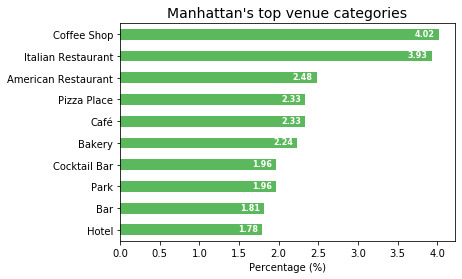

In [37]:
ax = (man_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Manhattan\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.3, b.y1-0.32), fontsize = 8, weight='bold', color='white')

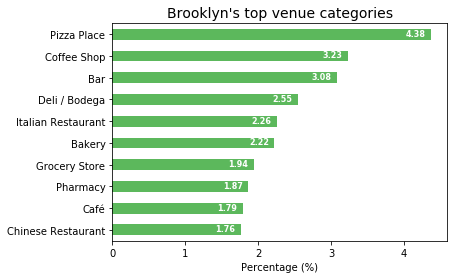

In [38]:
ax = (bln_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Brooklyn\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.35, b.y1-0.32), fontsize = 8, weight='bold', color='white')

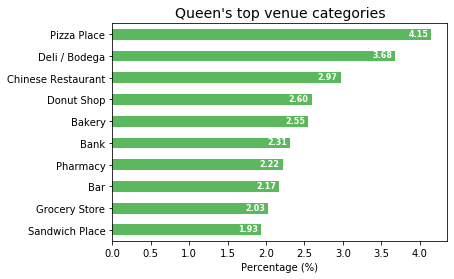

In [39]:
ax = (que_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Queen\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.3, b.y1-0.32), fontsize = 8, weight='bold', color='white')

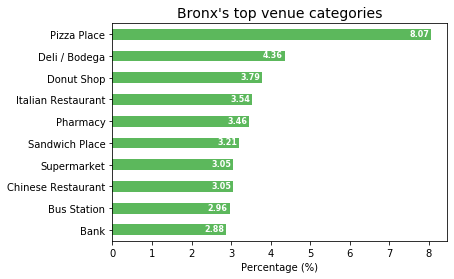

In [40]:
ax = (brx_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Bronx\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.55, b.y1-0.32), fontsize = 8, weight='bold', color='white')

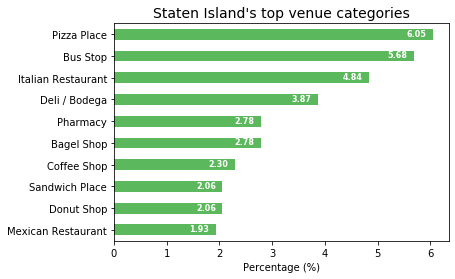

In [41]:
ax = (sta_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Staten Island\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.5, b.y1-0.32), fontsize = 8, weight='bold', color='white')

## 6. Filter the unique venue category in each borough.

Define a function to obtain the venue category of each borough.

In [42]:
def get_category(venue_name):
    df1=venue_name.groupby('Venue Category').size().reset_index(name="Count")
    df2 = df1.sort_values('Count', ascending=False)
    df2 = df2.set_index('Venue Category')
    return(df2)

Get the venue category of each borough.

In [43]:
man_venues=get_category(manhattan_venues)
bln_venues=get_category(brooklyn_venues)
que_venues=get_category(queens_venues)
brx_venues=get_category(bronx_venues)
sta_venues=get_category(staten_island_venues)

Extract the venue categories in other boroughs.

In [44]:
df1 = pd.concat([bln_venues, que_venues, brx_venues, sta_venues])
df2 = pd.concat([man_venues, que_venues, brx_venues, sta_venues])
df3 = pd.concat([man_venues, bln_venues, brx_venues, sta_venues])
df4 = pd.concat([man_venues, bln_venues, que_venues, sta_venues])
df5 = pd.concat([man_venues, bln_venues, que_venues, brx_venues])

In [45]:
temp1=list(df1.index)
temp2=list(df2.index)
temp3=list(df3.index)
temp4=list(df4.index)
temp5=list(df5.index)

In [46]:
man_venues.reset_index(inplace=True)
bln_venues.reset_index(inplace=True)
que_venues.reset_index(inplace=True)
brx_venues.reset_index(inplace=True)
sta_venues.reset_index(inplace=True)

Obtain the unique venue category in each borough.

In [47]:
man_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
bln_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
que_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
brx_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
sta_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)

In [48]:
man_unique=man_venues[~man_venues.Category.isin(temp1)]
bln_unique=bln_venues[~bln_venues.Category.isin(temp2)]
que_unique=que_venues[~que_venues.Category.isin(temp3)]
brx_unique=brx_venues[~brx_venues.Category.isin(temp4)]
sta_unique=sta_venues[~sta_venues.Category.isin(temp5)]

In [49]:
man_tmp = man_unique.reset_index(drop=True)
bln_tmp = bln_unique.reset_index(drop=True)
que_tmp = que_unique.reset_index(drop=True)
brx_tmp = brx_unique.reset_index(drop=True)
sta_tmp = sta_unique.reset_index(drop=True)

Display the unique venue categories in each borough.

In [50]:
man_tmp.head()

,Category,Count
0,Exhibit,8
1,Australian Restaurant,5
2,Memorial Site,3
3,Pet Café,3
4,Music School,3


In [51]:
bln_tmp.head()

,Category,Count
0,Piercing Parlor,2
1,Stadium,1
2,Auto Dealership,1
3,Event Service,1
4,Stationery Store,1


In [52]:
que_tmp.head()

,Category,Count
0,Colombian Restaurant,3
1,Shop & Service,2
2,Bath House,1
3,State / Provincial Park,1
4,College Basketball Court,1


In [53]:
brx_tmp.head()

,Category,Count
0,Track,2
1,Waste Facility,1
2,Shopping Plaza,1
3,River,1
4,Comic Shop,1


In [54]:
sta_tmp.head()

,Category,Count
0,Recording Studio,2
1,Toll Plaza,1
2,Sri Lankan Restaurant,1
3,Theme Park,1
4,Tex-Mex Restaurant,1


Replace space if there is any.

In [55]:
man = man_tmp.replace(' ', '', regex=True)
bln = bln_tmp.replace(' ', '', regex=True)
que = que_tmp.replace(' ', '', regex=True)
brx = brx_tmp.replace(' ', '', regex=True)
sta = sta_tmp.replace(' ', '', regex=True)

## 7. Visualize the unique venue category in each borough.

In [56]:
man_vis = man.set_index('Category')
bln_vis = bln.set_index('Category')
que_vis = que.set_index('Category')
brx_vis = brx.set_index('Category')
sta_vis = sta.set_index('Category')

Define a function to visualize the unique venue category in each borough.

In [57]:
def vis_unique_venue(dataset):
    word_string = ''
    for category in dataset.index.values:
        repeat_num_times = int(dataset.loc[category, 'Count'])
        word_string = word_string + ((category + ' ') * repeat_num_times)
        
    wordcloud = WordCloud(background_color='white').generate(word_string)
    # display the cloud
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(14)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

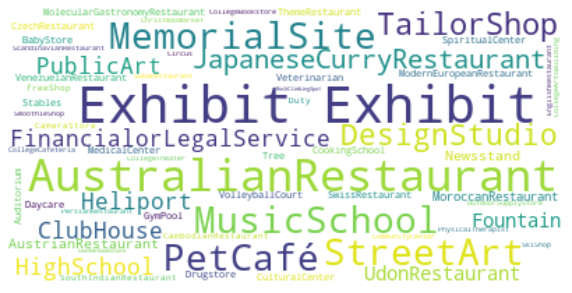

In [58]:
vis_unique_venue(man_vis)

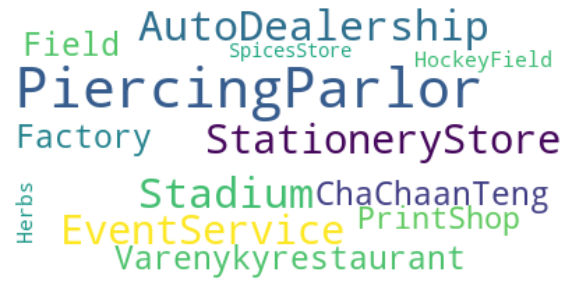

In [59]:
vis_unique_venue(bln_vis)

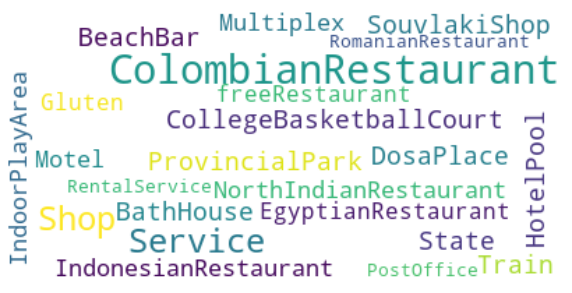

In [60]:
vis_unique_venue(que_vis)

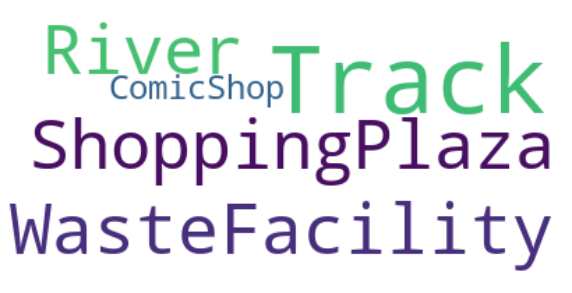

In [61]:
vis_unique_venue(brx_vis)

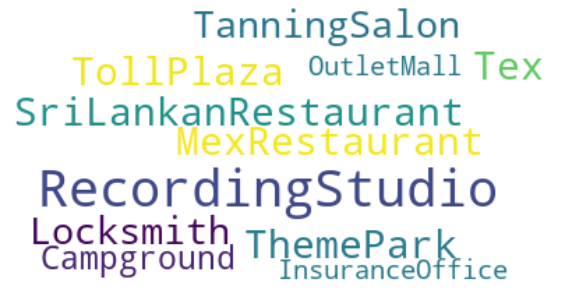

In [62]:
vis_unique_venue(sta_vis)